# An integrated diagnostic analysis of plasma waves

## Setup
Identify time ranges into which to separate the analysis. Locate crash times and define widows just before and just after them. Various plots shown to indicate suitability of ranges and windows.


Import necessary packages

In [1]:
from lib.imports_BES import *
from lib.analysis_functions_BES import *
from lib.analysis_functions_Mirnov import *
from lib.analysis_functions_general import *

Load BES data from various NETCDF files

In [2]:
# Specify path to where data is stored
bes_data_path = "BES_code_local/Data/"
shot = 29378
shotlabel = "\#" + str(shot)
markers = [',', '+', 'x', 'o', '*', '^']

# Dalpha data. Array for time and array for values
dalpha_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_dalpha.nc")
dalpha_time = np.asarray(dalpha_from_file.coords['time'])
dalpha_data = np.asarray(dalpha_from_file)

# Upper tangential Dalpha. Array for time and array for values
utda_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_upper_tan_dalpha.nc")
utda_time = np.asarray(utda_from_file.coords['time'])
utda_data = np.asarray(utda_from_file)

# Line-averaged density. Array for time and array for values
density_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_density.nc")
density_time = np.asarray(density_from_file.coords['time'])
density_data = np.asarray(density_from_file)

# Equilibria from EFIT. Two spacial arrays, a time array and 2D array of psi
equilib_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_equilibria.nc")
equilib_time = np.asarray(equilib_from_file.coords['time'])
equilib_R = np.asarray(equilib_from_file.coords['R'])
equilib_Z = np.asarray(equilib_from_file.coords['Z'])
equilib_psi = np.asarray(equilib_from_file)

# (R, z) locations for the BES channels. Shape: (32,2)
apdpos = np.asarray(xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_apdpos.nc"))

# Main BES data. Array for times and shape (32,time) array for fluctuation
fluct_data_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_LH_fluct_data.nc")
bes_time = np.asarray(fluct_data_from_file.coords['time'])
fluct_data = np.asarray(fluct_data_from_file)

Load Mirnov coil data

In [3]:
mirnov_data_path = "Mirnov_code_local/Data/"

# Get coil positions
coilpos = np.asarray(xr.open_dataarray(mirnov_data_path + "coil_positions.nc"))

# Main Mirnov data
mirnov_data_from_file = xr.open_dataarray(mirnov_data_path + "shot" + str(shot) + "_mirnov_data.nc")
mirnov_time = np.asarray(mirnov_data_from_file.coords['time'])
coil_nums = np.asarray(mirnov_data_from_file.coords['coil']) # Coil numbers e.g. 210 for coils in order of data
mirnov_data = np.asarray(mirnov_data_from_file) # Shape (11,650000)

# Useful coils appear to be [206, 207, 210, 212, 213, 214]
coil_nums = coil_nums[1:7]
mirnov_data = mirnov_data[1:7]
coilpos = coilpos[1:7]

Plot $D_\alpha$ data to identify times of interest then input ranges to separate analysis into. Change these as needed

In [4]:
# Change regions' bounds as needed
regions = [[0.16,0.24], [0.36,0.54], [0.54,0.68]]

# BES time is limited to ~0.65
for i in range(len(regions)):
    if regions[i][1] > bes_time[-1]:
        print("Region", i, "trimmed", str(regions[i]), "to", np.around([regions[i][0], bes_time[-1]],2))
        regions[i] = [regions[i][0], bes_time[-1]]

Region 2 trimmed [0.54, 0.68] to [0.54 0.65]


Plot regions so time ranges can be fine-tuned.

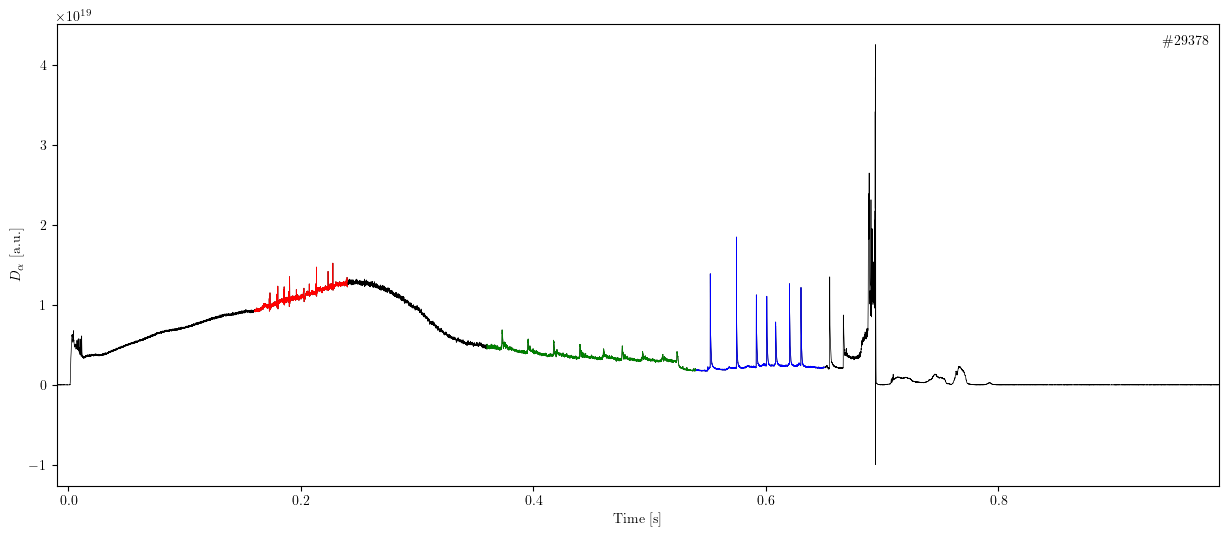

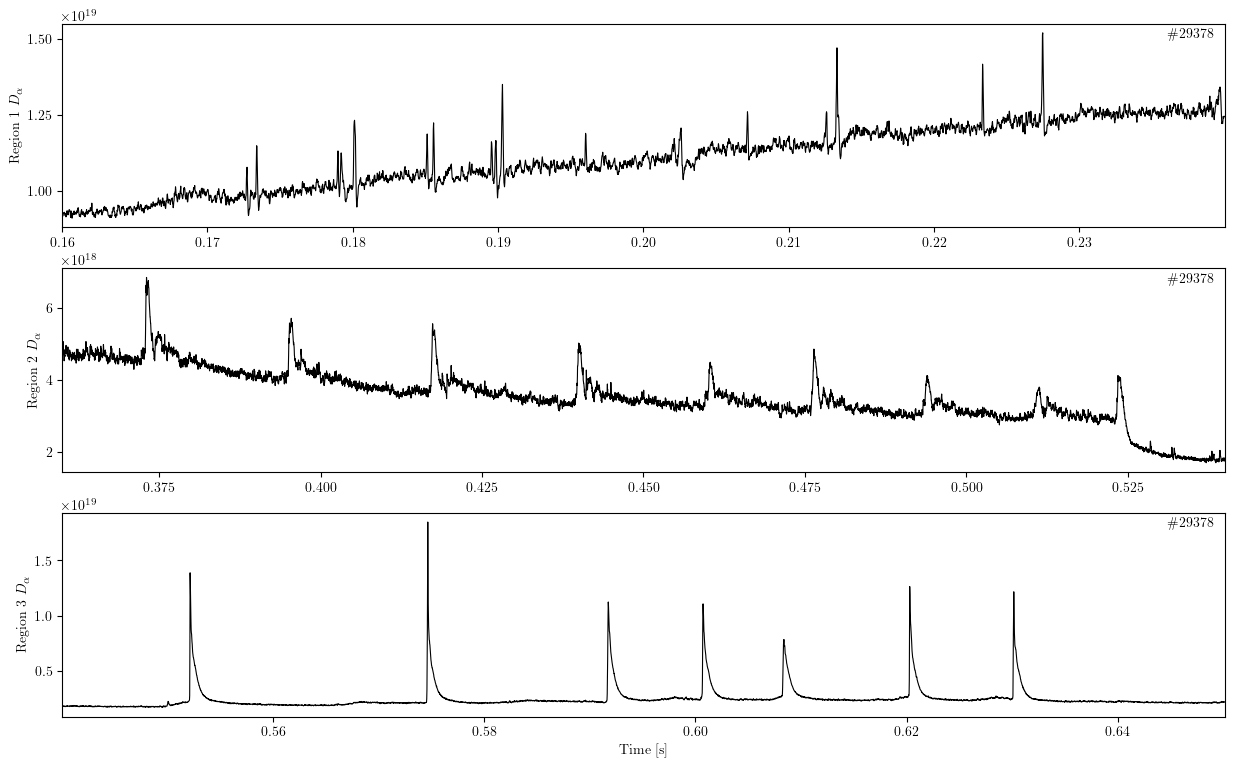

In [5]:
colours = ["r", "g", "b", "c", "m", "y"] # Each region plotted in different colour

# Big plot of Dalpha with regions differently colours
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 6))
ax1.plot(dalpha_time, dalpha_data, 'k', linewidth=0.5)

# Plots of each region separately
fig2, ax2 = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 9))

for i in range(len(regions)):
    idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
    idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()
    ax1.plot(dalpha_time[idx1:idx2+1], dalpha_data[idx1:idx2+1], colours[i], linewidth=0.5)
    
    ax2[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
    ax2[i].tick_params(axis='x')
    ax2[i].tick_params(axis='y')
    ax2[i].set_ylabel(r"Region " + str(i+1) + r" $D_\alpha$")
    ax2[i].locator_params(axis='y', nbins=3)
    ax2[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
    ax2[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax2[i].transAxes)

ax1.set_xlabel("Time [s]")
ax1.set_ylabel(r"$D_\alpha$ [a.u.]")
ax1.set_xlim([dalpha_time[0], dalpha_time[-1]])
ax1.text(.99, .975, shotlabel, ha='right', va='top', transform=ax1.transAxes)

ax2[-1].set_xlabel("Time [s]")

#fig1.savefig("Full_Dalpha_plot.pdf", format="pdf", bbox_inches="tight")
#fig2.savefig("Dalpha_region_plots.pdf", format="pdf", bbox_inches="tight")

plt.show()
plt.close()

Now use tangential $D_\alpha$ data to identify crash times. Set threshold for each region so that the blue line runs below most of the peaks while avoiding baseline noise.

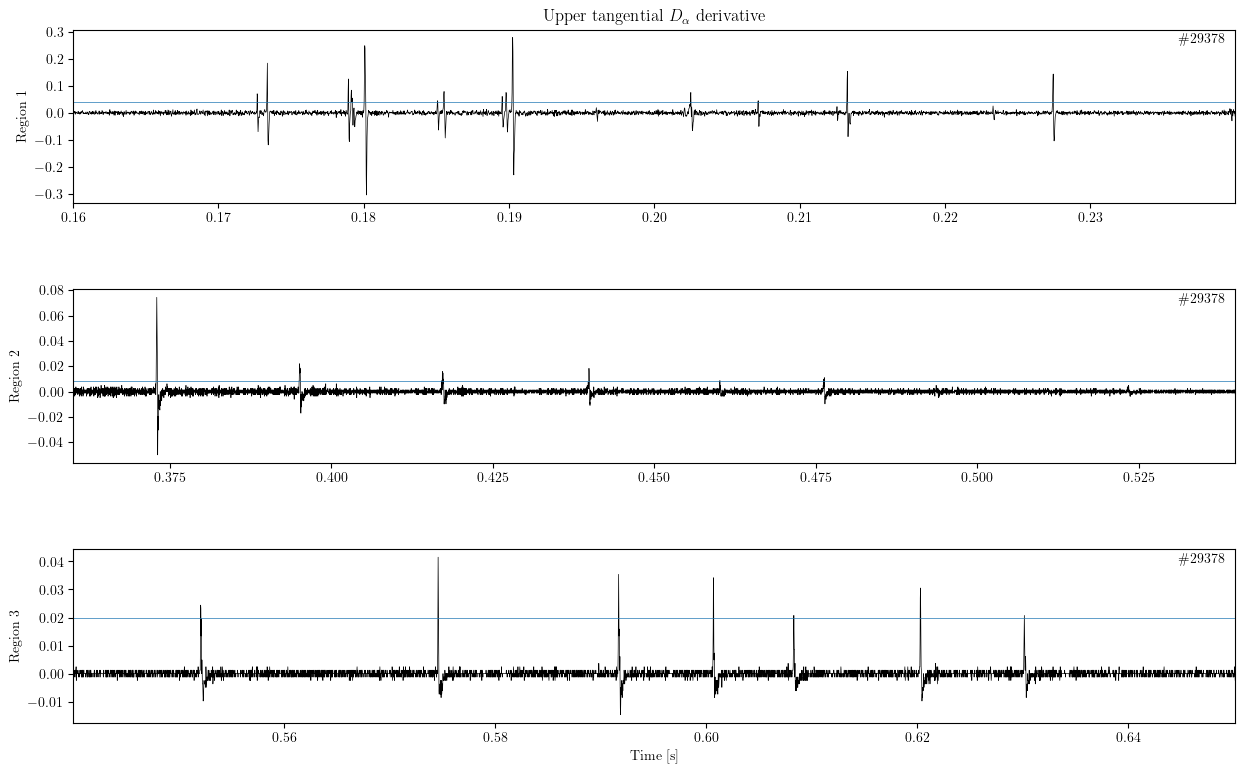

In [6]:
thresholds = [0.04, 0.008, 0.02]
figure, axes = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 9))

for i in range(len(regions)):
    idx1 = (np.abs(utda_time - regions[i][0])).argmin()
    idx2 = (np.abs(utda_time - regions[i][1])).argmin()
    
    axes[i].plot(utda_time[idx1:idx2], np.gradient(utda_data[idx1:idx2]), "k", linewidth=0.5)
    axes[i].hlines(thresholds[i], utda_time[idx1], utda_time[idx2], linewidth=0.5)
    axes[i].set_ylabel("Region " + str(i+1))
    axes[i].locator_params(axis="y", nbins=7)
    axes[i].text(.99, .975, shotlabel, ha='right', va='top', transform=axes[i].transAxes)
    axes[i].set_xlim([utda_time[idx1], utda_time[idx2]])

axes[-1].set_xlabel("Time [s]")
axes[0].set_title(r"Upper tangential $D_\alpha$ derivative")
plt.subplots_adjust(hspace=0.5)

plt.show()
plt.close()

Using thresholds defined above, find windows around crashes

Change start/end shifts as needed

In [12]:
pre_crash_windows = {}
post_crash_windows = {}
crash_times = {}

crash_times[0] = get_crash_times(utda_time, utda_data, thresholds[0], regions[0])
pre_crash_windows[0] = get_crash_adjacent_window(utda_time, utda_data, thresholds[0], regions[0], start_shift=2e-3, end_shift=0.5e-3)
post_crash_windows[0] = get_crash_adjacent_window(utda_time, utda_data, thresholds[0], regions[0], start_shift=-0.5e-3, end_shift=-2e-3)

crash_times[1] = get_crash_times(utda_time, utda_data, thresholds[1], regions[1])
pre_crash_windows[1] = get_crash_adjacent_window(utda_time, utda_data, thresholds[1], regions[1], start_shift=5e-3, end_shift=1e-3)
post_crash_windows[1] = get_crash_adjacent_window(utda_time, utda_data, thresholds[1], regions[1], start_shift=-1e-3, end_shift=-5e-3)

crash_times[2] = get_crash_times(utda_time, utda_data, thresholds[2], regions[2])
pre_crash_windows[2] = get_crash_adjacent_window(utda_time, utda_data, thresholds[2], regions[2], start_shift=5e-3, end_shift=1e-3)
post_crash_windows[2] = get_crash_adjacent_window(utda_time, utda_data, thresholds[2], regions[2], start_shift=-1e-3, end_shift=-5e-3)

Make some plots to check that windows found are sensible, readjust above as needed

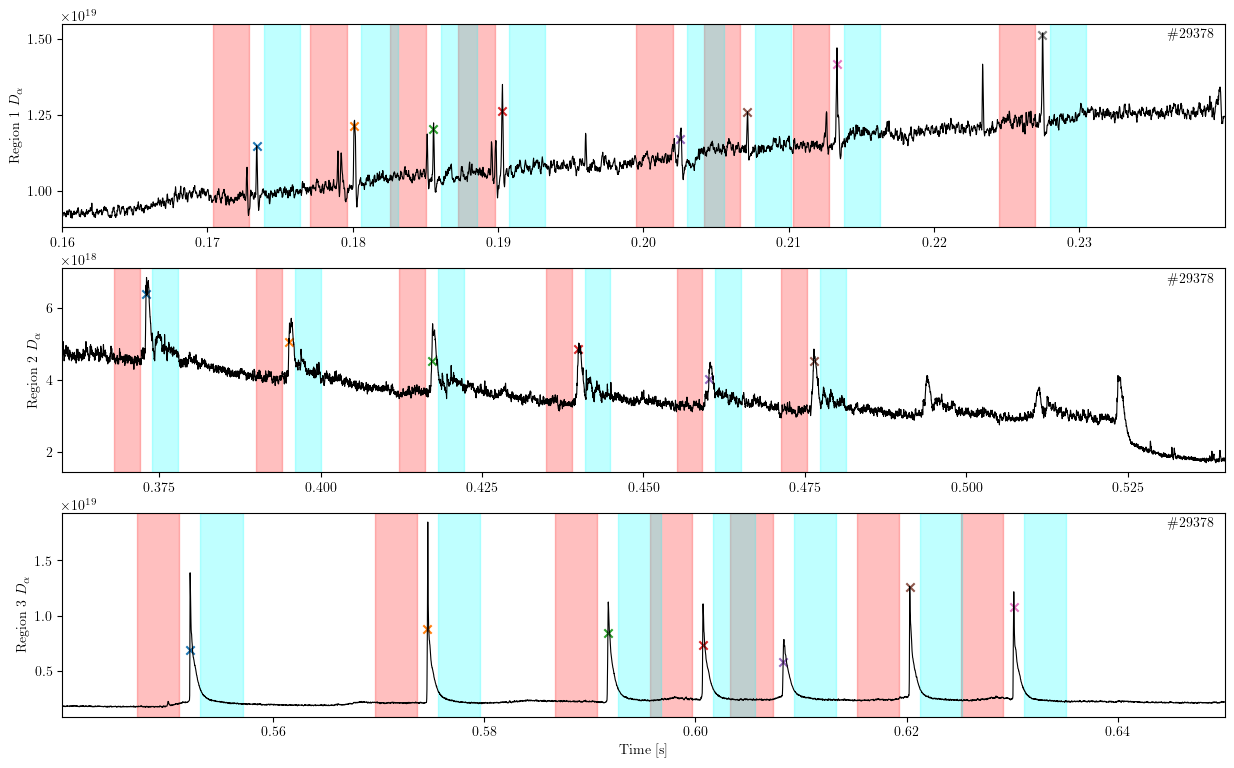

In [8]:
# Plots of each region separately with found crashes marked
fig, ax = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 3*len(regions)))

for i in range(len(regions)):
    idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
    idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()
    
    ax[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
    ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[i].transAxes)
    for peak in crash_times[i]:
        crash_amplitude = dalpha_data[(np.abs(dalpha_time - peak)).argmin()]
        ax[i].scatter(peak, crash_amplitude, marker="x")
        
    for pre_window in pre_crash_windows[i]:
        #ax[i].vlines(pre_window[0], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "g", linestyle="dashed", linewidth=0.5)
        #ax[i].vlines(pre_window[1], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "r", linestyle="dashed", linewidth=0.5)
        ax[i].axvspan(pre_window[0], pre_window[1], alpha=0.25, color='red')

    for post_window in post_crash_windows[i]:
        #ax[i].vlines(post_window[0], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "m", linestyle="dotted", linewidth=0.5)
        #ax[i].vlines(post_window[1], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "c", linestyle="dotted", linewidth=0.5)
        ax[i].axvspan(post_window[0], post_window[1], alpha=0.25, color='cyan')
    
    ax[i].tick_params(axis='x')
    ax[i].tick_params(axis='y')
    ax[i].set_ylabel(r"Region " + str(i+1) + r" $D_\alpha$")
    ax[i].locator_params(axis='y', nbins=3)
    ax[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
    ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax2[i].transAxes)

ax[-1].set_xlabel("Time [s]")
plt.show()
plt.close()

Show windows on spectrograms. Only one column plotted as they aren't significantly different - crashes appear at pretty much the same time in all columns.

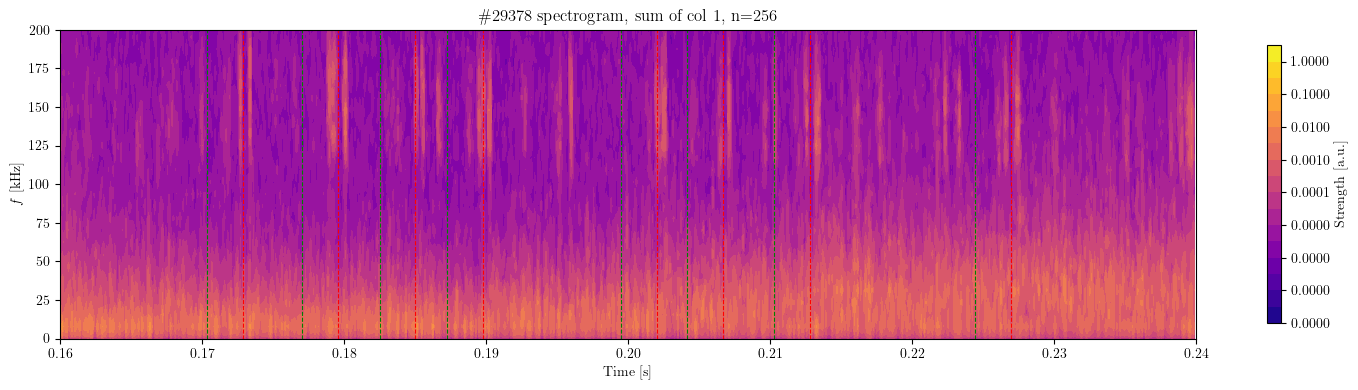

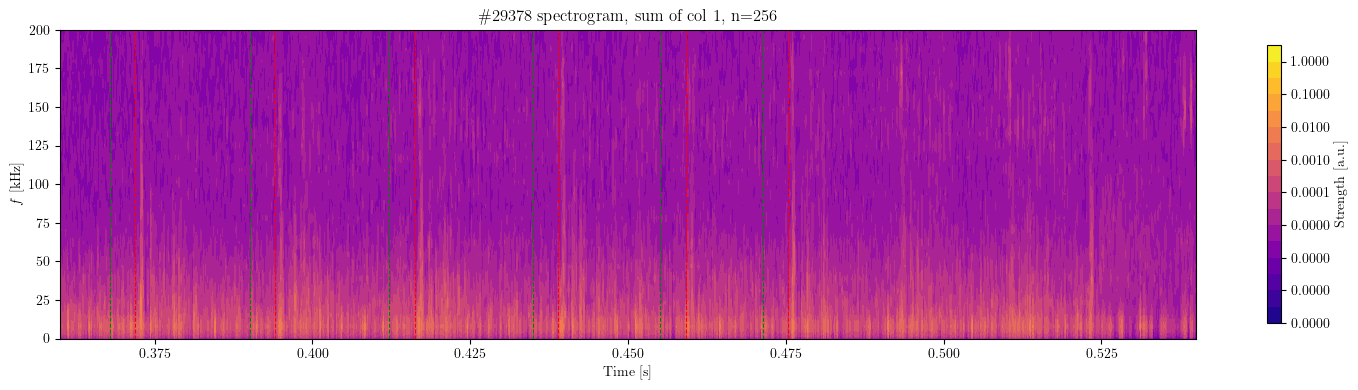

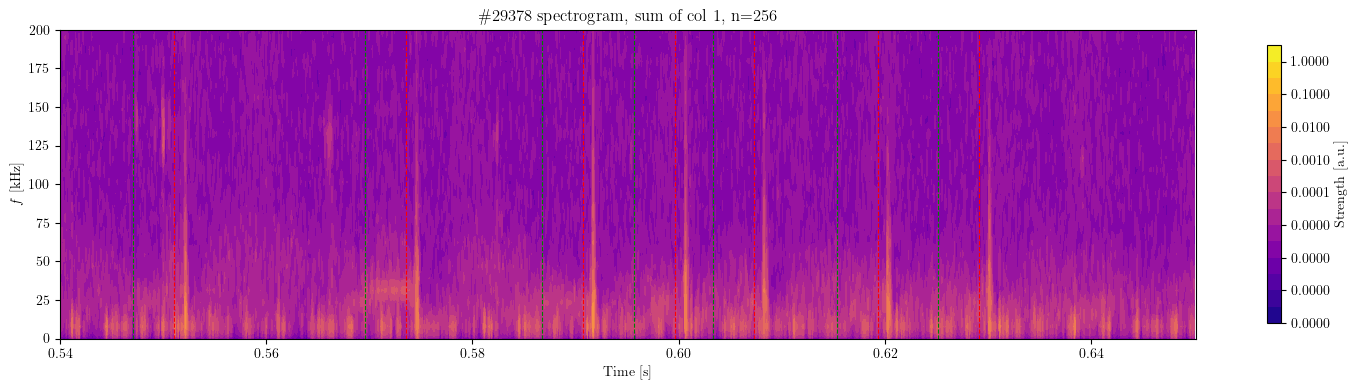

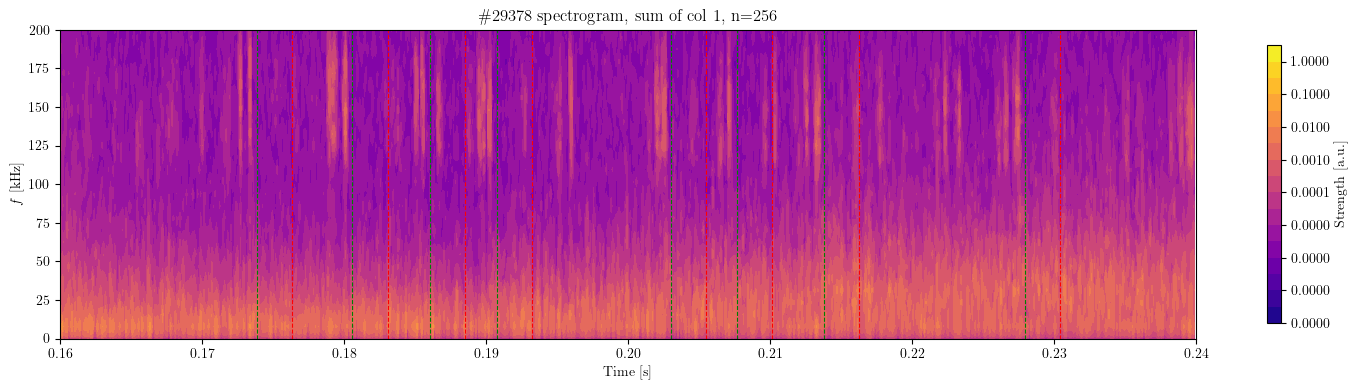

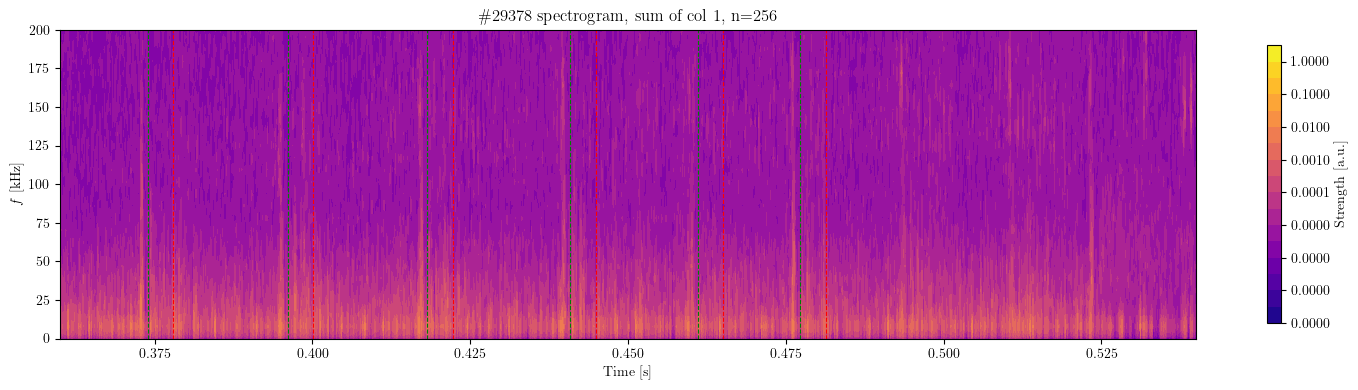

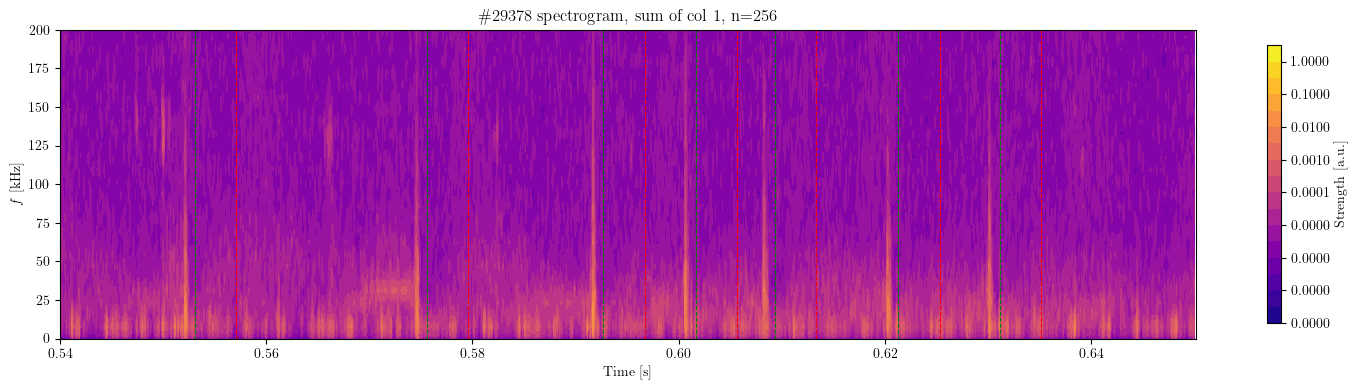

In [9]:
if True:
    # Show pre-crash windows first
    for i in range(len(regions)):
        sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 0, regions[i], vlines=pre_crash_windows[i], plot=True)

    # Then show post-crash windows
    for i in range(len(regions)):
        sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 0, regions[i], vlines=post_crash_windows[i], plot=True)

Once happy, calculate average distance of each column from separatrix over a given timeslice

In [10]:
if False:
    with open("dist_in_sol.csv", "w") as f:
        f.write("Region")
        for i in range(8):
            f.write(",Col " + str(i+1))
        f.write("\n")

        for region in range(len(regions)):
            f.write(str(region+1))
            for col in range(8):
                f.write("," + str(sol_dist(equilib_time, equilib_R, equilib_Z, equilib_psi, apdpos, regions[region], col)))
            f.write("\n")

dists_in_sol = pd.read_csv("BES_code_local/Data/dist_in_sol.csv", index_col=0)

# Analysis

By this point you should be happy with the regions and the pre- and post-crash windows.

Define timeslices that contain interesting features

In [11]:
chirps_down = [[0.384,0.3895], [0.411, 0.416], [0.427, 0.433], [0.449, 0.455]]
chirps_down_franges_mirnov = [ # Optimised for coil idx=2, plot profile non-log
    [[7000, 12000], [15000, 23000]],
    [[6000, 10000], [17000, 25000]],
    [[7000, 11000], [14000, 19500]],
    [[6000, 11000], [14500, 18500]]
]


elm_125 = [[0.5653,0.5665], [0.5816,0.5828], [0.595,0.596], [0.606,0.607], [0.618,0.619], [0.6267,0.628]]
elm_125_franges_bes = [ # Optimised for col idx=6, plot profile non-log
    [97500, 150000],
    [100000, 145000],
    [90000, 140000],
    [95000, 145000],
    [90000, 135000],
    [101000, 135000]
]

centres = [0.559, 0.6127, 0.624, 0.6335, 0.644]
elm_harmonics = [[i-0.0025, i+0.0025] for i in centres]
elm_harmo_franges_mirnov = [ # Optimised for coil idx=2
    [[8950, 13100], [18000, 25500], [29500,37500]],
    [[8000, 15000], [20050, 27150], [32000,39900]],
    [[10500, 16000], [22500, 29000], [36500,41500]],
    [[8000, 15000], [21500, 30000], [37500,43000]],
    [[7000, 14500], [18500, 25500], [29500,37500]]
]

elm_pcw = []
for i in range(len(elm_125)):
    elm_pcw.append(np.array([elm_125[i][1], crash_times[2][1:][i]-0.0005]))

Compare strengths of region 3 features to each other

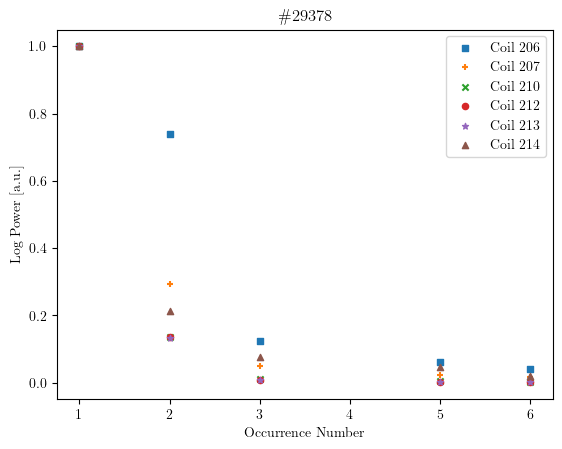

In [12]:
elm_125_franges_mirnov = [
    [[95000, 150000],[95000, 150000],[100000, 140000],[100000, 140000],[90000, 130000],[95000, 135000]],
    [[95000, 150000],[95000, 150000],[100000, 140000],[100000, 140000],[90000, 130000],[95000, 135000]],
    [[97500, 145000],[90000, 140000],[80000, 140000],[95000, 145000],[80000, 130000],[95000, 135000]],
    [[97500, 145000],[90000, 140000],[80000, 140000],[95000, 145000],[80000, 130000],[95000, 135000]],
    [[97500, 145000],[90000, 145000],[76000, 150000],[95000, 145000],[82000, 135000],[92000, 135000]],
    [[97500, 140000],[90000, 150000],[100000, 140000],[95000, 145000],[90000, 135000],[92000, 135000]],
    [[97500, 140000],[90000, 150000],[100000, 140000],[95000, 145000],[90000, 135000],[92000, 135000]]
]

fig, ax = plt.subplots(1,1)
for coil in range(6):
    pts = np.array([])
    for window in range(len(elm_125)):
        f_arr, kf_matrix = fft_channel(mirnov_time, mirnov_data, coil, elm_125[window])
        frange = elm_125_franges_mirnov[coil][window]
        p = get_f_profile(f_arr, kf_matrix, [50e3, 200e3], plot=False, vlines=frange)
        pt = get_f_area(p[0], p[1], frange)
        pts = np.append(pts, pt)
    pts = np.asarray([(pts[i-1]) for i in [1,2,3,5,6]])
    pts = pts/pts[0]
    ws = np.asarray([1,2,3,5,6])
    ax.scatter(ws, pts, marker=markers[coil], s=20, label="Coil " + str(coil_nums[coil]))

ax.set_xlabel("Occurrence Number")
ax.set_ylabel("Log Power [a.u.]")
ax.legend()
ax.set_title(shotlabel)
plt.savefig("Decay125.pdf", bbox_inches="tight")
plt.show()
#print(1-np.exp((np.log(pts[-1])-np.log(pts[0]))/6))

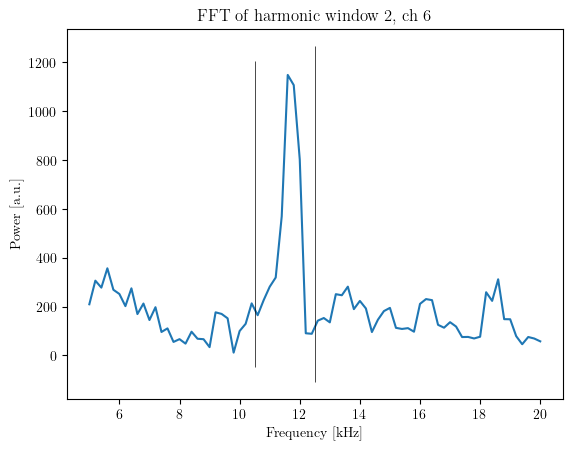

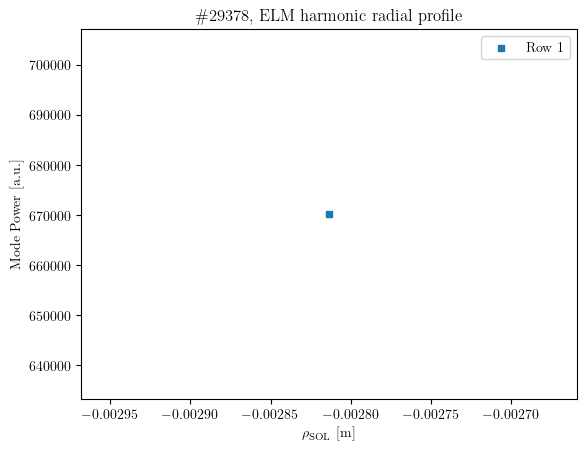

In [13]:
elm_125_ch_franges = [
    [95000,150000],
    [100000,160000],
    [100000,135000],
]

elm_precursor_ch_franges = [ # Not working
    [27000,36000],
    [16000,23500],
    [18000,24500],
    [17000,22500]
]

elm_harmonic_ch_franges = [[9500,13000],[10500,12500],[12500,13500]]

all_pts = []
all_rs = []

w = 1
for row in range(1):
    pts = np.array([])
    rs = []
    for col in range(5,6):
        f_arr, kf_matrix = fft_channel(bes_time, fluct_data, row*8+col, elm_harmonics[w])
        frange = elm_harmonic_ch_franges[w]
        p = get_f_profile(f_arr, kf_matrix, [5e3, 20e3], plot="FFT of harmonic window " + str(w+1) + ", ch " + str(row*8+col+1), vlines=frange, smooth_pts=3)
        pt = get_f_area(p[0], p[1], frange)
        pts = np.append(pts, pt)
        rs.append(channel_sol_dist(equilib_time, equilib_R, equilib_Z, equilib_psi, apdpos, elm_harmonics[w], row*8+col))
    all_pts.append(pts)
    all_rs.append(rs)

fig, ax = plt.subplots(1,1)
for i in range(len(all_pts)):
    ax.scatter(all_rs[i], all_pts[i], marker=markers[i], s=20, label="Row " + str(i+1))

pts = np.asarray(all_pts).flatten()
rs = np.asarray(all_rs).flatten()
# If removing anomalies from fit
#pts = np.delete(pts,12)
#rs = np.delete(rs,12)

"""popt, pcov = curve_fit(gaussian, rs, pts)
residuals = pts - gaussian(rs, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((pts - np.mean(pts))**2)
r_squared = 1 - (ss_res / ss_tot)
fit_x = np.linspace(rs[0], rs[-1], 100)
fit_y = gaussian(fit_x, *popt)
ax.plot(fit_x, fit_y, "k", linewidth=0.5, label="Gaussian fit")"""
    
ax.set_xlabel(r"$\rho_{\rm SOL}$ [m]")
ax.set_ylabel("Mode Power [a.u.]")
ax.set_title(shotlabel + ", ELM harmonic radial profile")# + ", $\mu=\,$" + str(np.round(popt[1],4)) + " m, $R^2=\,$" + str(np.round(r_squared,3)))
ax.legend()
#plt.savefig("rad_pcw_w"+str(w+1)+".pdf", bbox_inches="tight")
plt.show()

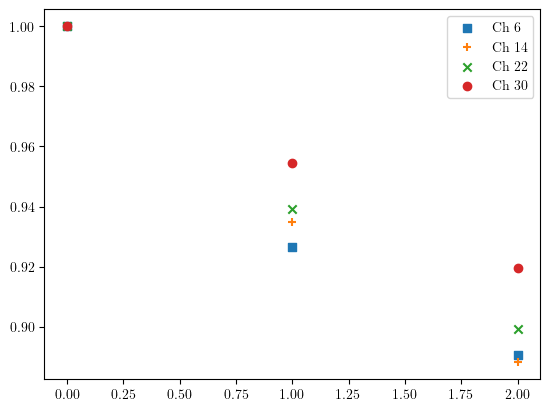

In [15]:
fig, ax = plt.subplots(1,1)
for row in range(4):
    decay_pts = np.array([])
    decay_ws = np.array([])
    for w in range(3):
        f_arr, kf_matrix = fft_channel(bes_time, fluct_data, row*8+6, elm_125[w])
        frange = elm_125_ch_franges[w]
        p = get_f_profile(f_arr, kf_matrix, [50e3, 200e3], plot=False, vlines=frange, smooth_pts=5)
        pt = get_f_area(p[0], p[1], frange)
        decay_pts = np.append(decay_pts, pt)
        decay_ws = np.append(decay_ws, w) 
    ax.scatter(decay_ws,np.log(decay_pts)/np.log(decay_pts)[0], label="Ch " + str(row*8+6), marker=markers[row])
    
ax.legend()
plt.show()

0.47817457330486524


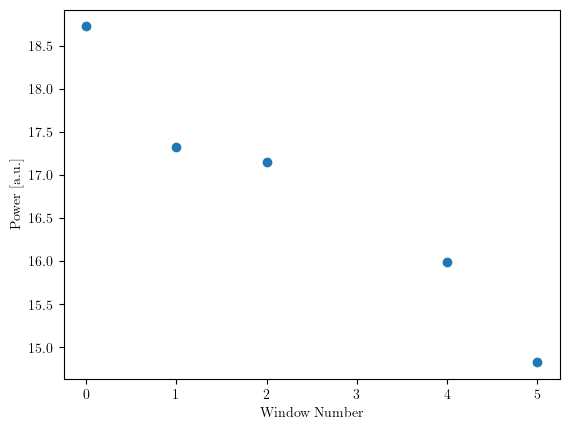

In [16]:
bes_areas = []
for window in range(len(elm_125)):
    f_arr, k_arr, kf_matrix = get_kf_spec(bes_time, fluct_data, apdpos, 5, elm_125[window])
    frange = elm_125_franges_bes[window]
    p = get_f_profile(f_arr, kf_matrix, [50e3, 200e3], plot=False, vlines=frange)
    pt = get_f_area(p[0], p[1], frange)
    bes_areas.append(pt)
bes_areas[3] = np.NaN
plt.scatter(np.arange(6), np.log(bes_areas))
plt.xlabel("Window Number")
plt.ylabel("Power [a.u.]")

"""sol_dist = np.round(dists_in_sol.loc[3].at["Col " + str(col)],2)
    plt.scatter(sol_dist, pt, color="k", marker="x")
    plt.xlabel("Column")
    plt.ylabel("Power [a.u.]")
plt.show()"""

print(1-np.exp((np.log(bes_areas[-1])-np.log(bes_areas[0]))/6))

In [17]:
pts = np.array([])
rs = np.array([])
for coil in range(len(coil_nums)):
    f_arr, f_profile = fft_channel(mirnov_time, mirnov_data, coil, elm_harmonics[0])
    frange = [9000, 13010]
    p = get_f_profile(f_arr, f_profile, [0e3, 50e3], plot=False, vlines=frange)
    pt = get_f_area(p[0], p[1], frange)
    dist = coil_to_sep(equilib_time, equilib_R, equilib_Z, equilib_psi, coilpos, elm_harmonics[0], coil)
    pts = np.append(pts, pt)
    rs = np.append(rs, dist)

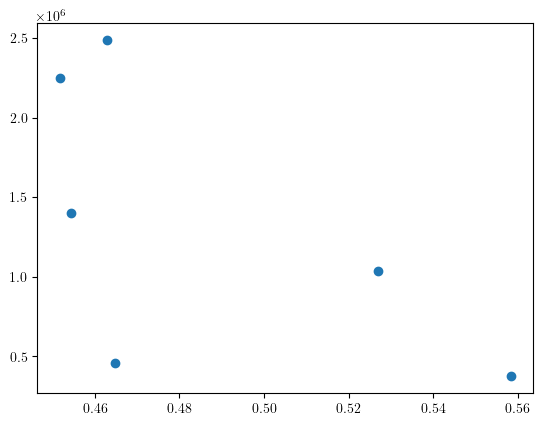

In [18]:
plt.scatter(rs, pts)
plt.show()

## Region 3 pre-crash windows better

In [19]:
elm_pcw = []
for i in range(len(elm_125)):
    elm_pcw.append(np.array([elm_125[i][1], crash_times[2][1:][i]-0.0005]))

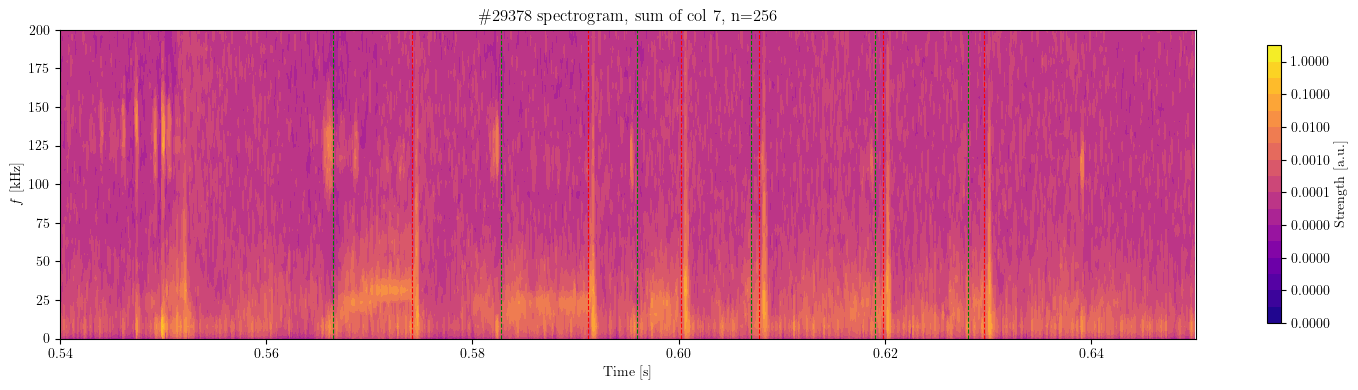

(array([      0.        ,    7812.50497685,   15625.0099537 ,
          23437.51493055,   31250.0199074 ,   39062.52488425,
          46875.0298611 ,   54687.53483795,   62500.0398148 ,
          70312.54479165,   78125.0497685 ,   85937.55474535,
          93750.0597222 ,  101562.56469905,  109375.0696759 ,
         117187.57465275,  125000.0796296 ,  132812.58460645,
         140625.0895833 ,  148437.59456015,  156250.099537  ,
         164062.60451385,  171875.1094907 ,  179687.61446756,
         187500.11944441,  195312.62442126,  203125.12939811,
         210937.63437496,  218750.13935181,  226562.64432866,
         234375.14930551,  242187.65428236,  250000.15925921,
         257812.66423606,  265625.16921291,  273437.67418976,
         281250.17916661,  289062.68414346,  296875.18912031,
         304687.69409716,  312500.19907401,  320312.70405086,
         328125.20902771,  335937.71400456,  343750.21898141,
         351562.72395826,  359375.22893511,  367187.73391196,
        

In [20]:
sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 6, regions[2], vlines=elm_pcw, plot=True)

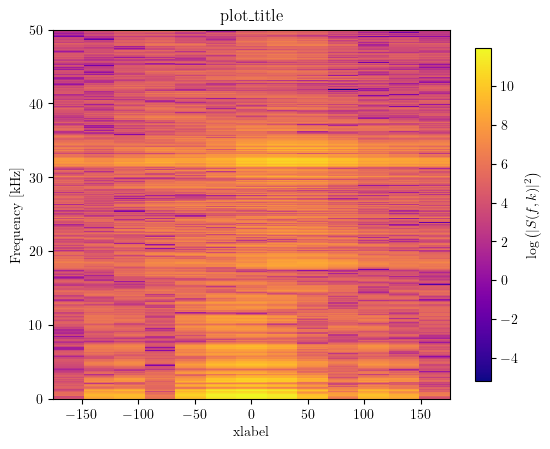

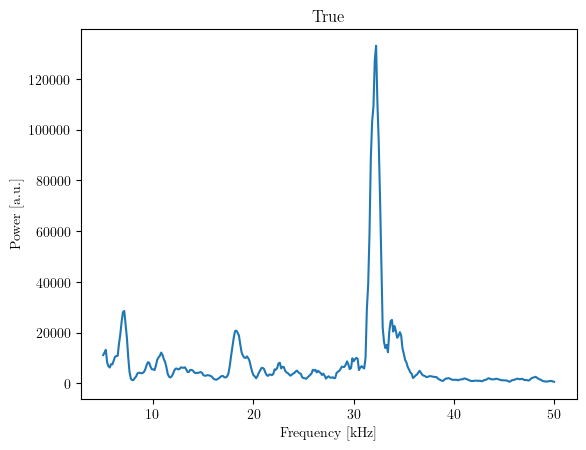

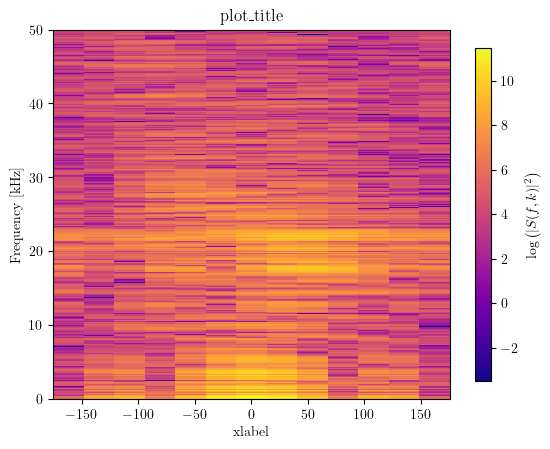

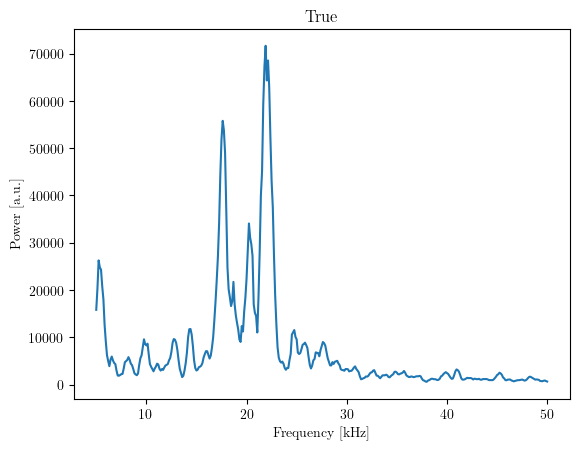

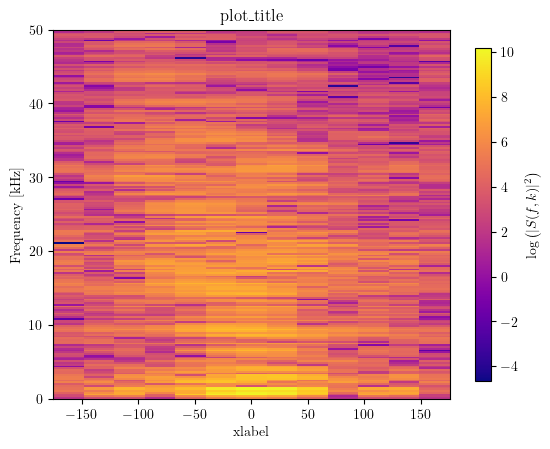

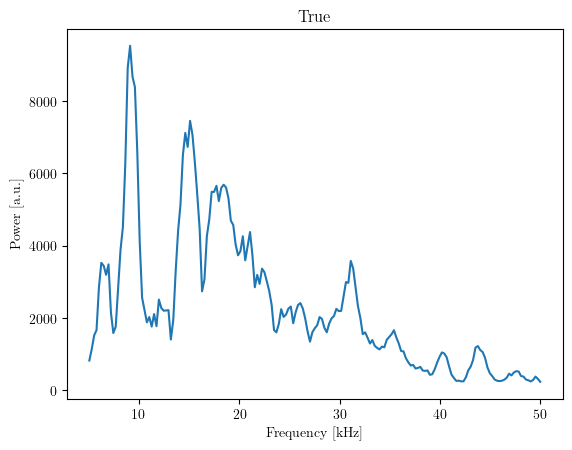

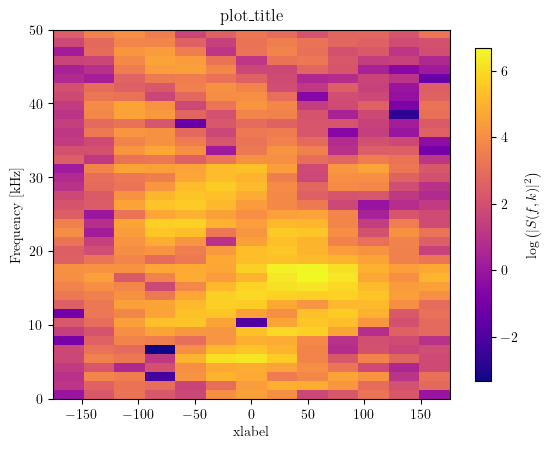

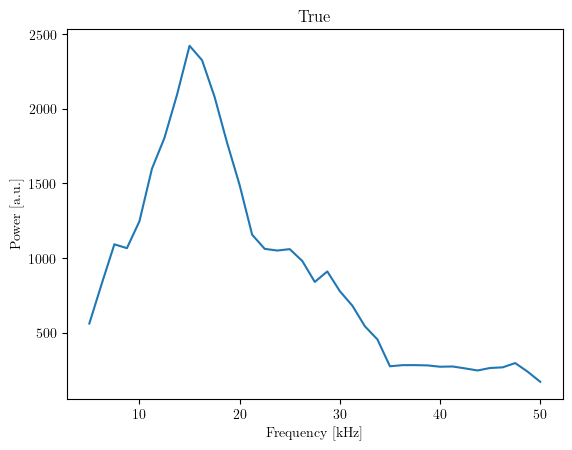

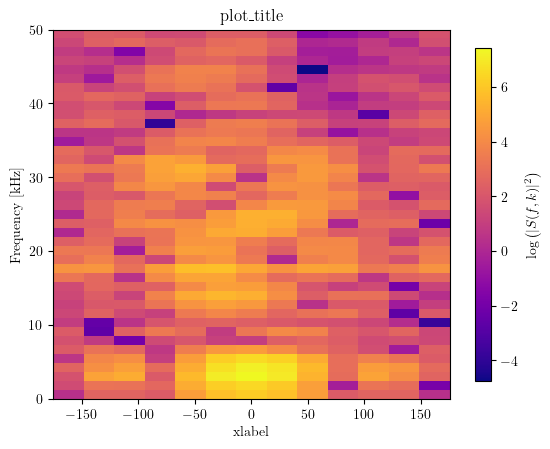

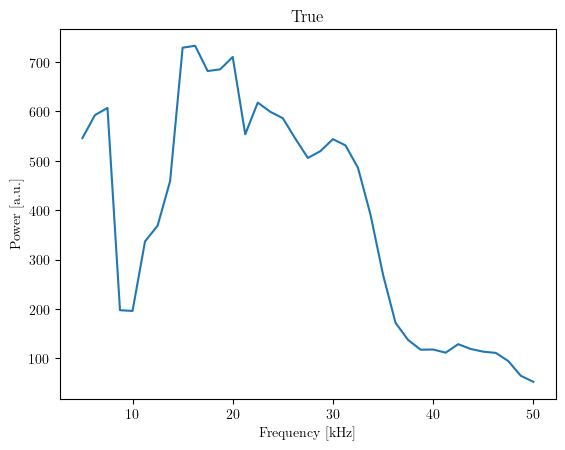

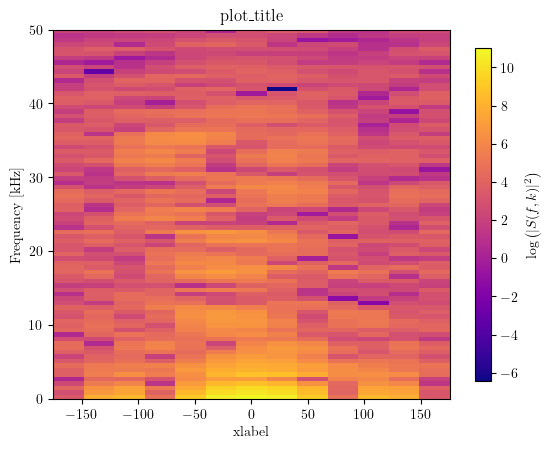

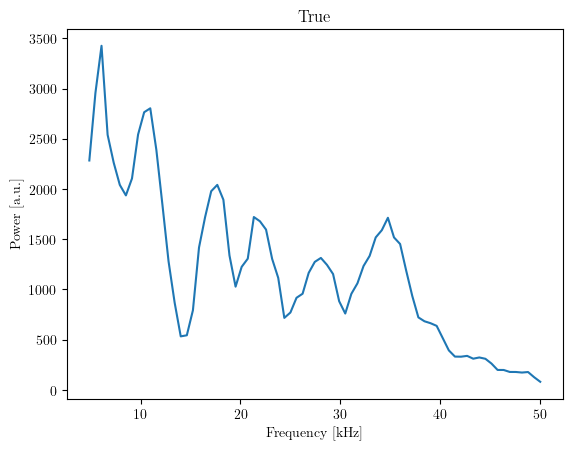

In [21]:
for i in elm_pcw:
    f_arr, k_arr, kf_matrix = get_kf_spec(bes_time, fluct_data, apdpos, 6, i)
    plot_dispersion_relation(f_arr, k_arr, kf_matrix, "plot_title", "xlabel", fmin=0.0e3, fmax=50.0e3, smooth_pts=5, conditional=False, save=False)
    get_f_profile(f_arr, kf_matrix, [5e3, 50e3], plot=True, vlines=None)

0.0001013655975056901


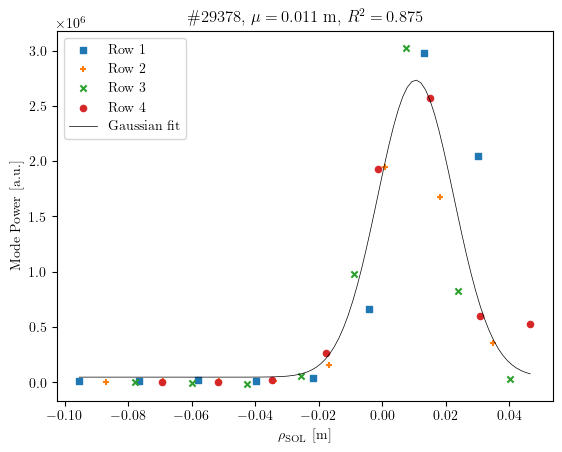

In [26]:
all_pts = []
all_rs = []
elm_pcw_ch_franges = [[27000,37500], [16000,24000]]

w = 0
for row in range(4):
    pts = np.array([])
    rs = []
    for col in range(8):
        f_arr, kf_matrix = fft_channel(bes_time, fluct_data, row*8+col, elm_harmonics[w])
        frange = [9e3,13e3]
        p = get_f_profile(f_arr, kf_matrix, [5e3, 35e3], plot=False, vlines=frange, smooth_pts=5)
        pt = get_f_area(p[0], p[1], frange)
        pts = np.append(pts, pt)
        rs.append(channel_sol_dist(equilib_time, equilib_R, equilib_Z, equilib_psi, apdpos, elm_harmonics[w], row*8+col))
    all_pts.append(pts)
    all_rs.append(rs)

fig, ax = plt.subplots(1,1)
for i in range(len(all_pts)):
    ax.scatter(all_rs[i], all_pts[i], marker=markers[i], s=20, label="Row " + str(i+1))
    
pts = np.asarray(all_pts).flatten()
rs = np.asarray(all_rs).flatten()

print(pts[3]*1e-8)
pts = np.delete(pts, 3)
rs = np.delete(rs, 3)

popt, pcov = curve_fit(gaussian, rs, pts)
residuals = pts - gaussian(rs, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((pts - np.mean(pts))**2)
r_squared = 1 - (ss_res / ss_tot)
fit_x = np.linspace(rs[0], rs[-1], 100)
fit_y = gaussian(fit_x, *popt)
ax.plot(fit_x, fit_y, "k", linewidth=0.5, label="Gaussian fit")
    
ax.set_xlabel(r"$\rho_{\rm SOL}$ [m]")
ax.set_ylabel("Mode Power [a.u.]")
ax.legend()
ax.set_title(shotlabel + ", $\mu=\,$" + str(np.round(popt[1],3)) + " m, $R^2=\,$" + str(np.round(r_squared,3)))

plt.savefig("rad_precs_w"+str(w+1)+".pdf", bbox_inches="tight")
plt.show()

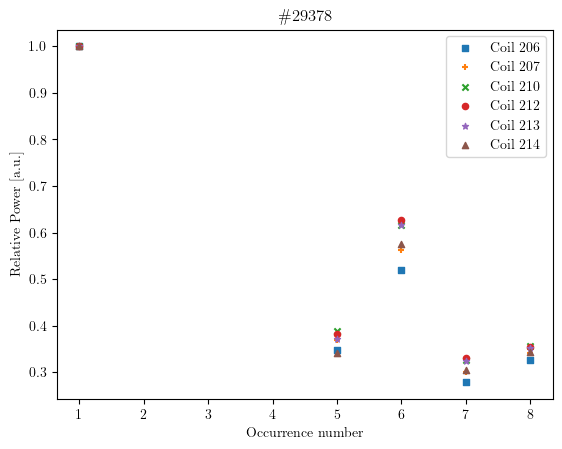

In [50]:
fig, ax = plt.subplots(1,1)

for coil in range(6):
    pts = np.array([])
    for window in range(len(elm_harmonics)):
        f_arr, kf_matrix = fft_channel(mirnov_time, mirnov_data, coil, elm_harmonics[window])
        frange = elm_harmo_franges_mirnov[window][0]
        p = get_f_profile(f_arr, kf_matrix, [10e3, 30e3], plot=False, vlines=frange)
        pt = get_f_area(p[0], p[1], frange)
        pts = np.append(pts, pt)
    ws = np.asarray([1,5,6,7,8])
    ax.scatter(ws, pts/pts[0], marker=markers[coil], s=20, label="Coil " + str(coil_nums[coil]))

ax.set_xlabel("Occurrence number")
ax.set_xticks(np.arange(1,9))
ax.set_ylabel("Relative Power [a.u.]")
ax.set_title(shotlabel)
ax.legend()
plt.savefig("DecayHarmonics.pdf", bbox_inches="tight")
plt.show()
plt.close()

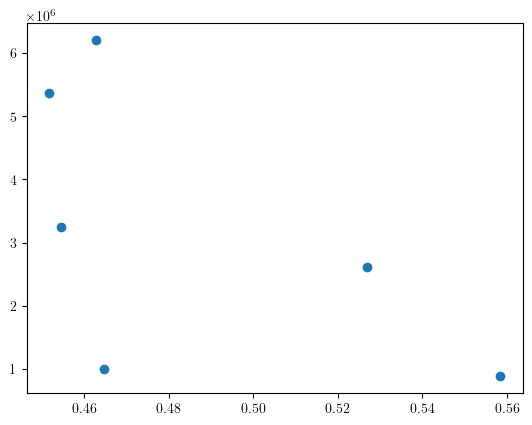

In [110]:
fig, ax = plt.subplots(1,1)
pts = np.array([])
dists  = np.array([])

for coil in range(6):
    f_arr, kf_matrix = fft_channel(mirnov_time, mirnov_data, coil, chirps_down[0])
    frange = chirps_down_franges_mirnov[0][1]
    p = get_f_profile(f_arr, kf_matrix, [10e3, 30e3], plot=False, vlines=frange)
    pts = np.append(pts, get_f_area(p[0], p[1], frange))
    dists = np.append(dists, coil_to_sep(equilib_time, equilib_R, equilib_Z, equilib_psi, coilpos, elm_harmonics[0], coil))

plt.scatter(dists, pts)
plt.show()